# Compare kriging and cokriging prediction results

Notes:
- ratio cokriging uncertainty / kriging uncertainty is nearly unity everywhere
  - this is likely because we are very data rich in SIF with this setup, and XCO2 is at the same locations
- it seems that since there's overlap in the data, using too large of a prediction window can result in nonsingular covariance matrices
- if doing joint prediction, the joint (data) covariance matrix will occationally be nonsingular, in which case point prediction is required

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from cmcrameri import cm

import fields
import model
import joint_prediction as prediction
import plot
from data_utils import get_main_coords

%matplotlib inline

In [3]:
with xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc") as ds:
    ds = ds.where(ds.time.dt.year > 2014, drop=True)
da_evi = xr.open_dataarray("../data/exp_pro/MODIS_05deg_monthly_conus_new.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var", "evi"]]

month_xco2 = "2016-11-01"
month_sif = "2016-10-01"
# month_xco2 = "2016-08-01"
# month_sif = "2016-07-01"

# Prediction setup
# max_dist = 1.3e3

## Collect SIF data for comparison
---

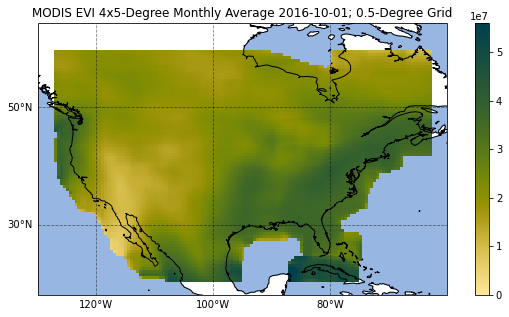

In [4]:
plot.plot_da(da_evi.sel(time=month_sif), vmin=0, title=f"MODIS EVI 4x5-Degree Monthly Average {month_sif}; 0.5-Degree Grid")

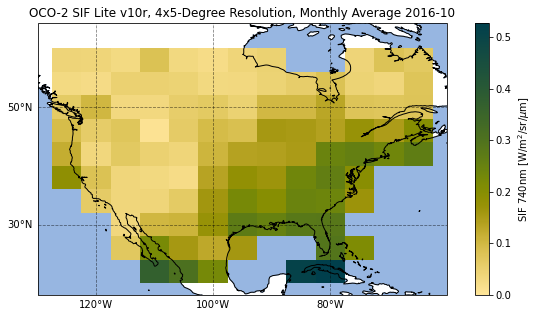

In [5]:
ds_show = get_main_coords(ds_sif).sel(time=month_sif)
title = f"OCO-2 SIF Lite v10r, 4x5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_show.time, unit='M')}"
units="SIF 740nm [W/m$^2$/sr/$\mu$m]"
plot.plot_da(ds_show.sif, vmin=0, title=title, label=units)

In [6]:
df_data_xco2 = (
    get_main_coords(ds_xco2)["xco2"]
    .sel(time=month_xco2)
    .to_dataframe()
    .reset_index()
    .drop(columns="time")
    .dropna(subset=["xco2"])
)
df_data_sif = (
    get_main_coords(ds_sif)["sif"]
    .sel(time=month_sif)
    .to_dataframe()
    .reset_index()
    .drop(columns="time")
    .dropna(subset=["sif"])
)
df_data_sif


,lon,lat,sif
4,-125.0,38.0,0.185717
5,-125.0,42.0,0.118038
6,-125.0,46.0,0.090999
7,-125.0,50.0,0.062259
8,-125.0,54.0,0.027264
...,...,...,...
125,-65.0,42.0,0.265431
126,-65.0,46.0,0.200476
127,-65.0,50.0,0.076262
128,-65.0,54.0,0.076138


## Produce and check kriging results
---

In [7]:
# Setup
datasets = [ds_sif]
covariates = [["evi"]]
timedeltas = [0]
vario_config = fields.VarioConfig(1500, 30, n_procs=1)

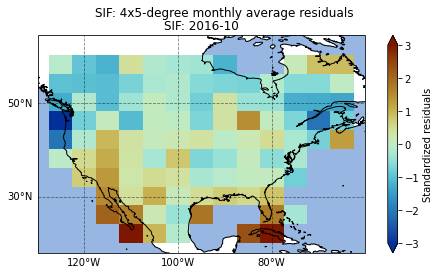

In [8]:
mf = fields.MultiField(
        datasets, covariates, np.datetime64(month_sif), timedeltas
    )
gamma = mf.empirical_variograms(vario_config)
plot.plot_fields(mf, ["SIF"])

In [9]:
df_sif_res = mf.fields[0].to_dataframe(main=True)[["lon", "lat", "sif"]]
df_sif_res

,lon,lat,sif
4,-125.0,38.0,-0.068961
5,-125.0,42.0,-2.091181
6,-125.0,46.0,-3.138037
7,-125.0,50.0,-1.285702
8,-125.0,54.0,-0.995443
...,...,...,...
125,-65.0,42.0,1.261150
126,-65.0,46.0,-0.776671
127,-65.0,50.0,-1.338476
128,-65.0,54.0,-0.021374


In [10]:
mod = model.MultivariateMatern(n_procs=1)
mod.fit(gamma)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,0.834344,"(0.4, 3.5)"
1,nu_11,0.821155,"(0.2, 3.5)"
2,len_scale_11,526.406939,"(100.0, 2000.0)"
3,nugget_11,0.020296,"(0.0, 0.2)"


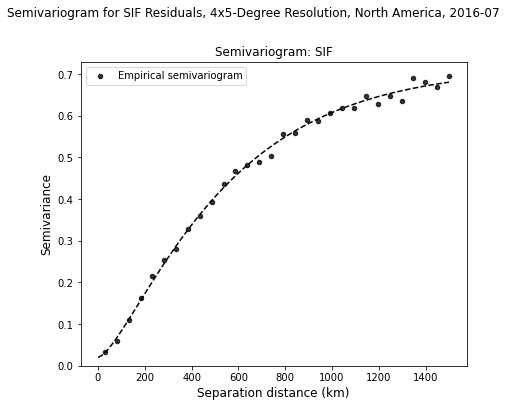

In [11]:
title = "Semivariogram for SIF Residuals, 4x5-Degree Resolution, North America, 2016-07"
plot.plot_variograms(mod.fit_result, ["SIF"], title=title)

In [12]:
pcoords = prediction.prediction_coords()
krig = prediction.Predictor(mod, mf, covariates=da_evi)
ds_krig = krig(0, pcoords)
# ds_krig = P(0, pcoords, postprocess=False)

/Users/joshjacobson/Projects/sif-data-fusion/research/../src/joint_prediction.py:63: UserWarning: Prediction joint covariance matrix is not positive definte; model technically invalid.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/joint_prediction.py:78: RuntimeWarning: invalid value encountered in sqrt
  df_pred["pred_err"] = np.nan_to_num(np.sqrt(np.diagonal(pred_var_cov_mat)))


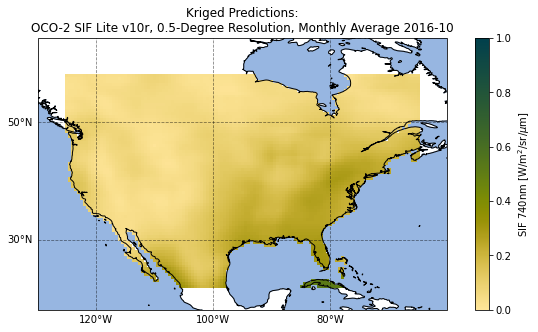

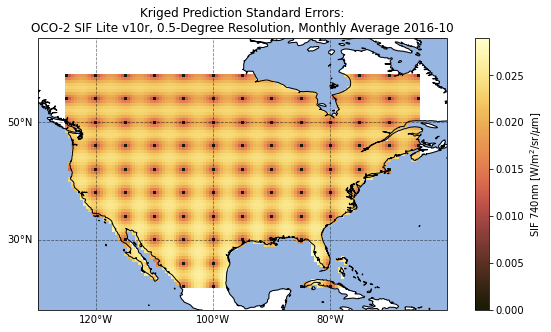

In [13]:
title_pred = f"Kriged Predictions:\nOCO-2 SIF Lite v10r, 0.5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_krig.time, unit='M')}"
title_err = f"Kriged Prediction Standard Errors:\nOCO-2 SIF Lite v10r, 0.5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_krig.time, unit='M')}"
units = "SIF 740nm [W/m$^2$/sr/$\mu$m]"
plot.plot_da(ds_krig.pred, vmin=0, vmax=1, title=title_pred, label=units)
plot.plot_da(ds_krig.pred_err, cmap=cm.lajolla_r, title=title_err, label=units)
# residuals
# plot.plot_da(ds_krig.pred, cmap=cm.roma_r)
# plot.plot_da(ds_krig.pred_err, cmap=cm.lajolla_r, vmin=0)

In [14]:
df_krig = (
    ds_krig.to_dataframe()
    .reset_index()
    .drop(columns=["time", "covariates"])
    .dropna(subset=["pred"])
    .merge(df_data_sif, on=["lon", "lat"], how="right")
)
# df_krig = (
#     ds_krig.to_dataframe()
#     .reset_index()
#     .drop(columns=["time"])
#     .dropna(subset=["pred"])
#     .merge(df_sif_res, on=["lon", "lat"], how="right")
# )
df_krig["diff"] = df_krig["sif"] - df_krig["pred"]
df_krig[["diff", "pred_err"]].describe()


,diff,pred_err
count,8.700000e+01,8.700000e+01
mean,-6.021807e-10,3.533180e-10
std,2.991387e-09,4.129771e-10
min,-1.010589e-08,0.000000e+00
25%,-2.165682e-09,0.000000e+00
50%,-1.645514e-10,0.000000e+00
75%,8.097035e-10,7.750193e-10
max,8.142083e-09,1.342373e-09


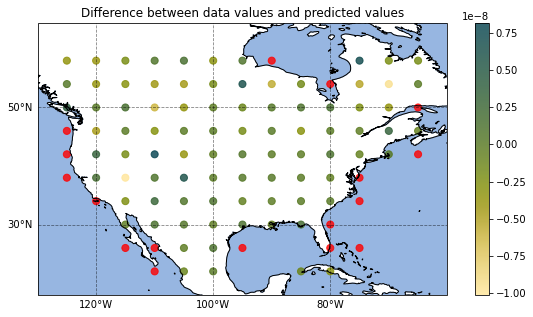

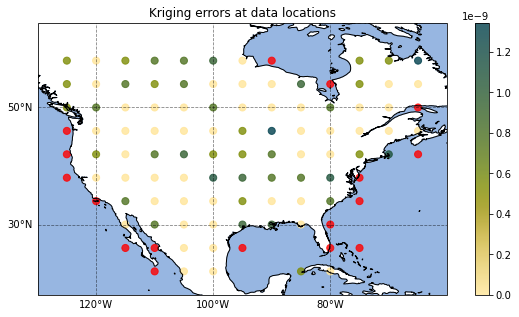

In [15]:
plot.plot_df(df_krig, "diff", s=50, title="Difference between data values and predicted values")
plot.plot_df(df_krig, "pred_err", s=50, title="Kriging errors at data locations")

## Produce and check cokriging results
---

In [16]:
# Setup
datasets = [ds_xco2, ds_sif]
covariates = [["lon", "lat"], ["evi"]]
timedeltas = [0, -1]
vario_config = fields.VarioConfig(1500, 30, n_procs=2)

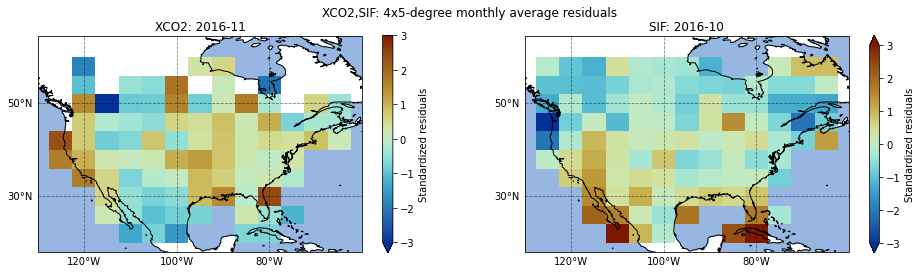

In [17]:
mf = fields.MultiField(
        datasets, covariates, np.datetime64(month_xco2), timedeltas
    )
gamma = mf.empirical_variograms(vario_config)
plot.plot_fields(mf, ["XCO2", "SIF"])

In [18]:
df_sif_res = mf.fields[1].to_dataframe(main=True)[["lon", "lat", "sif"]]
df_sif_res

,lon,lat,sif
4,-125.0,38.0,-0.068961
5,-125.0,42.0,-2.091181
6,-125.0,46.0,-3.138037
7,-125.0,50.0,-1.285702
8,-125.0,54.0,-0.995443
...,...,...,...
125,-65.0,42.0,1.261150
126,-65.0,46.0,-0.776671
127,-65.0,50.0,-1.338476
128,-65.0,54.0,-0.021374


In [19]:
mf.fields[1].values.size

1761

In [20]:
mod = model.MultivariateMatern(n_procs=2)
mod.fit(gamma)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,0.988554,"(0.4, 3.5)"
1,sigma_22,0.813300,"(0.4, 3.5)"
2,nu_11,0.390812,"(0.2, 3.5)"
3,nu_12,3.499987,"(0.2, 3.5)"
4,nu_22,0.998611,"(0.2, 3.5)"
5,len_scale_11,446.350416,"(100.0, 2000.0)"
6,len_scale_12,499.967591,"(100.0, 2000.0)"
7,len_scale_22,468.516220,"(100.0, 2000.0)"
8,nugget_11,0.000000,"(0.0, 0.2)"
9,nugget_22,0.024783,"(0.0, 0.2)"


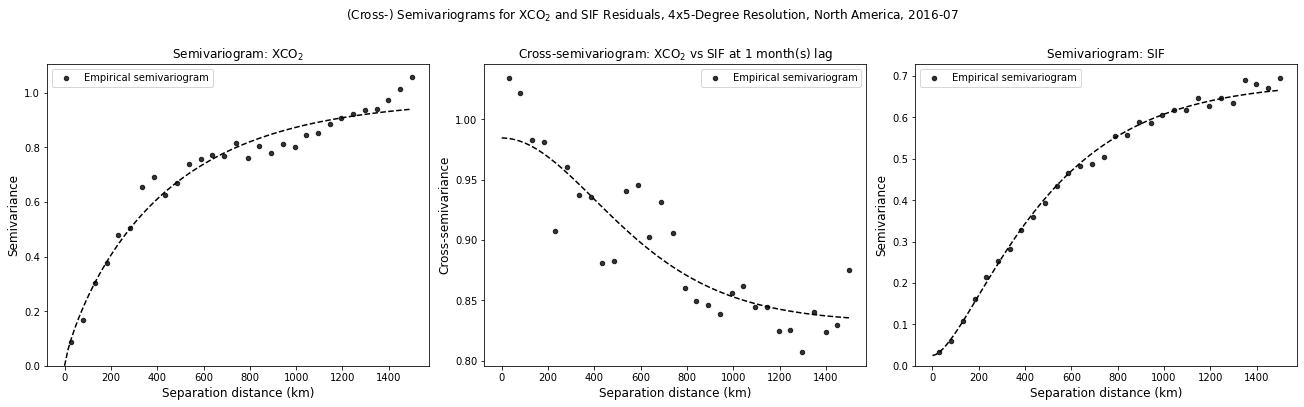

In [21]:
title = "(Cross-) Semivariograms for XCO$_2$ and SIF Residuals, 4x5-Degree Resolution, North America, 2016-07"
plot.plot_variograms(mod.fit_result, ["XCO$_2$", "SIF"], title=title)

In [22]:
pcoords = prediction.prediction_coords()
cokrig = prediction.Predictor(mod, mf, covariates=da_evi)
ds_cokrig = cokrig(1, pcoords)
# ds_cokrig = P(1, pcoords, postprocess=False)
# P = prediction.Predictor(mod, mf)
# ds_cokrig = P(0, pcoords)

/Users/joshjacobson/Projects/sif-data-fusion/research/../src/joint_prediction.py:63: UserWarning: Prediction joint covariance matrix is not positive definte; model technically invalid.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/joint_prediction.py:78: RuntimeWarning: invalid value encountered in sqrt
  df_pred["pred_err"] = np.nan_to_num(np.sqrt(np.diagonal(pred_var_cov_mat)))


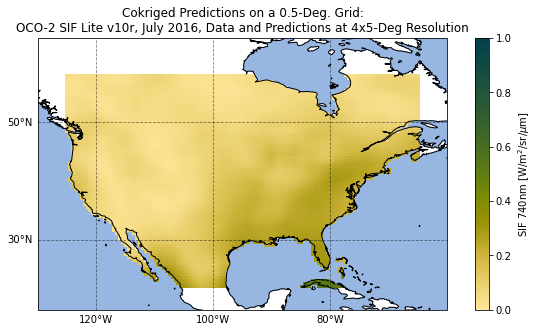

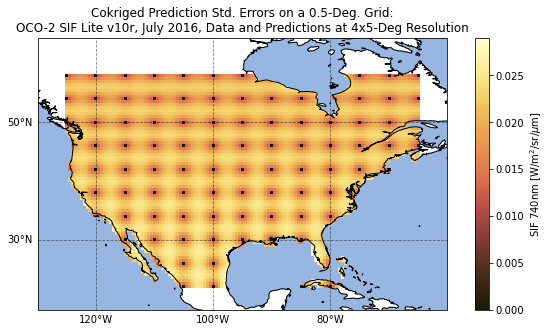

In [23]:
# title_pred = f"Cokriged Predictions:\nOCO-2 SIF Lite v10r, 0.5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_cokrig.time, unit='M')}"
# title_err = f"Cokriged Prediction Standard Errors:\nOCO-2 SIF Lite v10r, 0.5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_cokrig.time, unit='M')}"
title_pred = f"Cokriged Predictions on a 0.5-Deg. Grid:\nOCO-2 SIF Lite v10r, July 2016, Data and Predictions at 4x5-Deg Resolution"
title_err = f"Cokriged Prediction Std. Errors on a 0.5-Deg. Grid:\nOCO-2 SIF Lite v10r, July 2016, Data and Predictions at 4x5-Deg Resolution"
units = "SIF 740nm [W/m$^2$/sr/$\mu$m]"
plot.plot_da(ds_cokrig.pred, vmin=0, vmax=1, title=title_pred, label=units, filename="SIF_predictions")
plot.plot_da(ds_cokrig.pred_err, cmap=cm.lajolla_r, title=title_err, label=units, filename="SIF_uncertainty")
# residuals
# plot.plot_da(ds_cokrig.pred, cmap=cm.roma_r)
# plot.plot_da(ds_cokrig.pred_err, cmap=cm.lajolla_r, vmin=0)

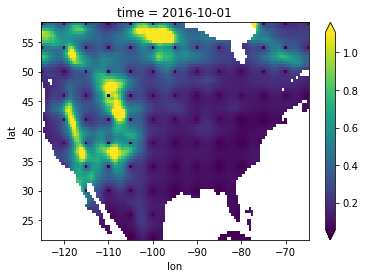

In [24]:
(ds_cokrig.pred_err / ds_cokrig.pred).T.plot(robust=True)

In [25]:
df_cokrig = (
    ds_cokrig.to_dataframe()
    .reset_index()
    # .drop(columns=["time", "covariates"])
    .drop(columns=["time"])
    .dropna(subset=["pred"])
    .merge(df_data_sif, on=["lon", "lat"], how="right")
)
# df_cokrig = (
#     ds_cokrig.to_dataframe()
#     .reset_index()
#     .drop(columns=["time"])
#     .dropna(subset=["pred"])
#     .merge(df_sif_res, on=["lon", "lat"], how="right")
# )
df_cokrig["diff"] = df_cokrig["sif"] - df_cokrig["pred"]
df_cokrig[["diff", "pred_err"]].describe()


,diff,pred_err
count,8.700000e+01,8.700000e+01
mean,-6.021807e-10,2.092392e-10
std,2.991387e-09,3.088642e-10
min,-1.010589e-08,0.000000e+00
25%,-2.165682e-09,0.000000e+00
50%,-1.645514e-10,0.000000e+00
75%,8.097035e-10,5.480214e-10
max,8.142083e-09,1.096043e-09


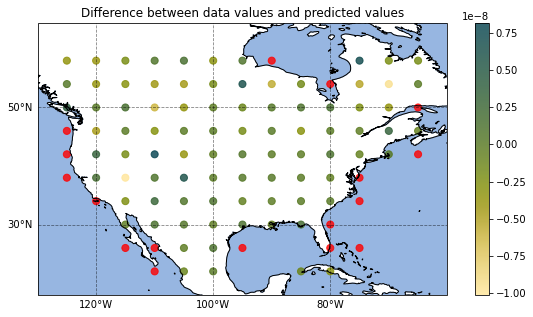

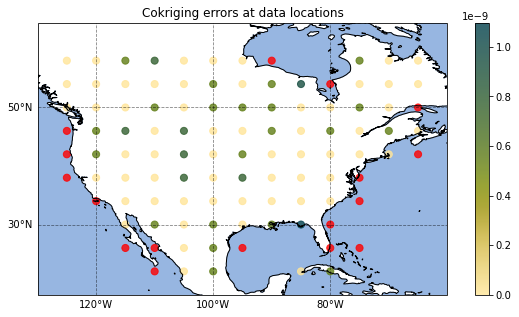

In [26]:
plot.plot_df(df_cokrig, "diff", s=50, title="Difference between data values and predicted values")
plot.plot_df(df_cokrig, "pred_err", s=50, title="Cokriging errors at data locations")

## Produce error ratio comparison map

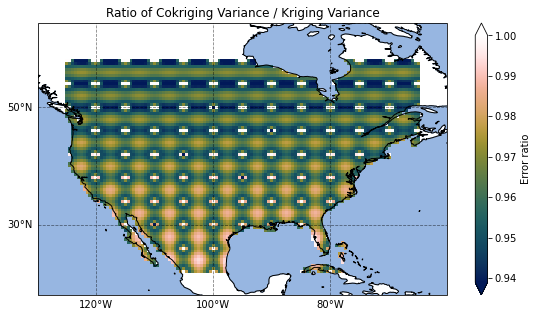

In [27]:
df_cokrig_err = (
    ds_cokrig["pred_err"].to_dataframe().reset_index().drop(columns="time").dropna()
)
df_krig_err = (
    ds_krig["pred_err"].to_dataframe().reset_index().drop(columns="time").dropna()
)
df_err_ratio = pd.merge(
    df_cokrig_err,
    df_krig_err,
    on=["lon", "lat"],
    how="outer",
    suffixes=["_cokrig", "_krig"],
)
df_err_ratio["ratio"] = (df_err_ratio["pred_err_cokrig"]**2) / (df_err_ratio["pred_err_krig"]**2)
df_err_ratio["ratio"][df_err_ratio["ratio"] == 0.0] = np.nan
with pd.option_context("mode.use_inf_as_null", True):
    df_err_ratio.fillna(1, inplace=True)

da_err_ratio = df_err_ratio.set_index(["lon", "lat"]).to_xarray()["ratio"]

title = "Ratio of Cokriging Variance / Kriging Variance"
plot.plot_da(da_err_ratio, cmap=cm.batlowW, title=title, label="Error ratio", robust=True)

NOTE: In the figure above, cokriging standard error decreases linearly with latitude because geodesic distance decreases with latitude

## Model Validation
---

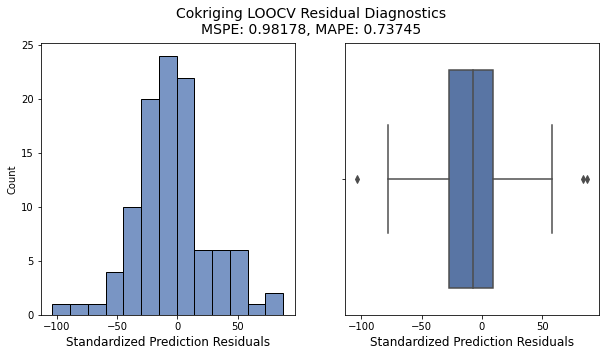

In [28]:
df_cv_cokrig = cokrig.cross_validation(1)
# df_cv_cokrig = cokrig.cross_validation(1, postprocess=False)
plot.plot_cv_resid(df_cv_cokrig, method="Cokriging")

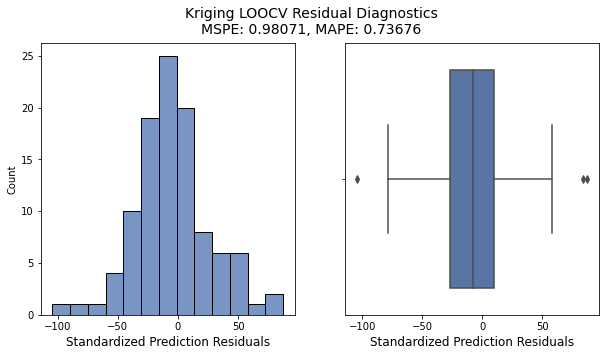

In [29]:
df_cv_krig = krig.cross_validation(0)
# df_cv_krig = krig.cross_validation(0, postprocess=False)
plot.plot_cv_resid(df_cv_krig, method="Kriging")